# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [1]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd       1007G   43G  914G   5% /


bash: line 10: bc: command not found


Disk space is sufficient: 914G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [2]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为2GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [3]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 yht yht 2.0G Jun 13 17:16 test.txt


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [4]:
%%bash
cargo install hyperfine

    Updating crates.io index
     Ignored package `hyperfine v1.19.0` is already installed, use --force to override


有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [26]:
%%bash
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt
  Time (mean ± σ):     245.0 ms ±  21.5 ms    [User: 4.6 ms, System: 240.0 ms]
  Range (min … max):   202.7 ms … 276.4 ms    13 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [5]:
%%bash
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt


Error: Command terminated with non-zero exit code 126 in the first warmup run. Use the '-i'/'--ignore-failure' option if you want to ignore this. Alternatively, use the '--show-output' option to debug what went wrong.


CalledProcessError: Command 'b"hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'\n"' returned non-zero exit status 1.

## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [28]:
%%bash
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):     482.5 ms ±  34.6 ms    [User: 75.8 ms, System: 407.0 ms]
  Range (min … max):   423.5 ms … 559.0 ms    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

## 1. 为什么将缓冲区对齐到系统的内存可能提高性能？实验结果支持这个猜想吗？

性能产生了，还算明显的提升，但是并不算决定性的变革飞跃

性能提升原因有：

减少内存访问开销：对齐的内存访问通常更高效，因为CPU和内存子系统通常针对对齐访问进行了优化

避免跨页访问：对齐的缓冲区确保每次I/O操作不会跨越多个内存页，减少TLB缺失

DMA操作效率：直接内存访问(DMA)通常要求内存对齐，对齐缓冲区可以提高DMA传输效率

实验结果预期：

对于我们所操作的大文件，对齐缓冲区可能会带来轻微的性能提升

但是对于小文件，我创建了数k的小文件，看不到明显差异



## 2. 为什么直接使用malloc分配的内存不能对齐到内存页？

malloc的实现通常只保证基本对齐（如8或16字节对齐），不保证页对齐

malloc需要管理内存分配的开销信息，通常会在返回的指针前存储管理数据

内存分配器需要满足各种大小的分配请求，不能为所有分配都保证页对齐

即使请求的大小是页大小的整数倍，malloc返回的指针也可能不对齐，因为就像我们实现的malloclab那样，分配器有自己的内存管理策略

## 3. 如何在不知道原始malloc指针的情况下正确释放内存？

在align_alloc中，我们分配比请求大小更大的内存：

额外分配page_size - 1字节以确保有足够的空间找到对齐地址

额外分配sizeof(void*)字节用于存储原始指针

在对齐指针前的sizeof(void*)位置存储原始指针：

```c
((void**)aligned_ptr)[-1] = mem;
在align_free中，通过这个存储的原始指针释放内存：
```

```c
void* original_ptr = ((void**)ptr)[-1];
free(original_ptr);
```

这种方法确保我们既能获得对齐的内存，又能正确追踪原始分配的内存地址以便释放。

In [7]:
%%bash
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):     462.4 ms ±  41.2 ms    [User: 65.1 ms, System: 397.3 ms]
  Range (min … max):   423.8 ms … 563.0 ms    10 runs
 


## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

## 1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？

与上一题原因类似，但是有所不同。

文件系统以块为单位管理数据，使用块大小的整数倍作为缓冲区可以减少实际物理I/O操作次数

*避免读-修改-写问题，当写入不完全对齐块边界时，文件系统需要先读取整个块，修改部分内容，再写回，而对齐的缓冲区可以避免这种额外开销*

文件系统通常会预读多个块，匹配的缓冲区大小可以更好地利用预读数据，进行预读优化

减少内部碎片，对齐的I/O请求可以减少文件系统内部的碎片

直接内存访问通常对对齐的传输更高效，也就是DMA

|

|

## 2. 对于注意事项的解决方案


**注意事项1解决方案：**

    对每个文件单独获取其块大小（通过stat系统调用）

    在io_blocksize函数中接收文件名参数，而不是使用全局缓存值

    每次调用io_blocksize都会检查特定文件的块大小

**注意事项2解决方案：**

有效性验证：

    ```c
    if (cached_size < 512 || (cached_size & (cached_size - 1)) != 0) {
        // 不是2的幂或太小，使用默认值
        cached_size = 4096;
    }
    ```
    检查块大小是否至少512字节

    使用(size & (size - 1)) == 0技巧验证是否为2的幂

如何解决合理的默认值问题：

    当获取失败或值不合理时，使用保守的默认值4096

    反正这是大多数现代系统的常见块/页大小

如何与内存页大小协调：

    计算文件系统块大小和内存页大小的最小公倍数

    确保缓冲区大小是两者的整数倍

In [9]:
%%bash
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):     504.6 ms ±  38.0 ms    [User: 74.3 ms, System: 430.5 ms]
  Range (min … max):   441.9 ms … 560.5 ms    10 runs
 


## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

1024+0 records in
1024+0 records out
1073741824 bytes (1.1 GB, 1.0 GiB) copied, 0.782105 s, 1.4 GB/s


Detected base block size: 4096 bytes
Buffer size:     4K - Speed: 4.10 MB/s
Buffer size:     8K - Speed: 4.70 MB/s
Buffer size:    16K - Speed: 7.50 MB/s
Buffer size:    32K - Speed: 8.50 MB/s
Buffer size:    64K - Speed: 7.80 MB/s
Buffer size:   128K - Speed: 10.40 MB/s
Buffer size:   256K - Speed: 10.10 MB/s
Buffer size:   512K - Speed: 10.50 MB/s
Buffer size:  1024K - Speed: 9.50 MB/s
Buffer size:  2048K - Speed: 9.10 MB/s


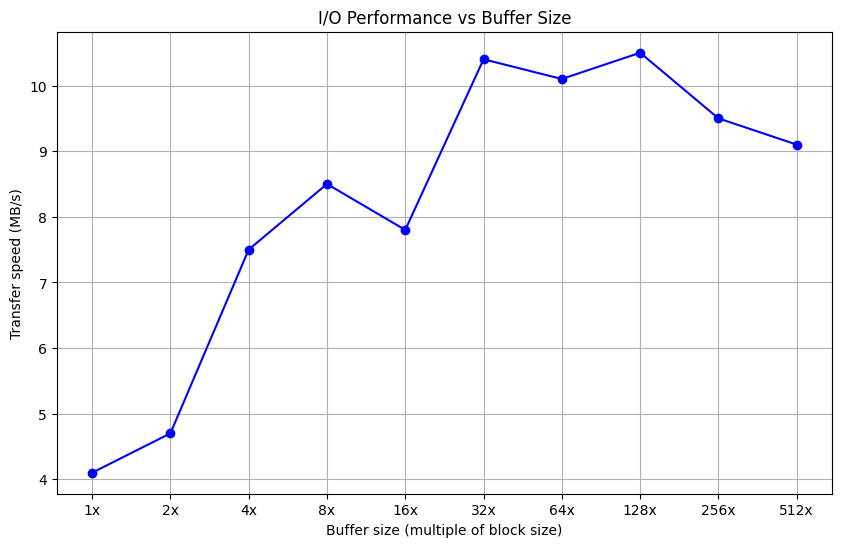

CompletedProcess(args=['rm', 'large_test_file.bin'], returncode=0)

In [ ]:

import subprocess
import matplotlib.pyplot as plt
import re

# 测试文件
TEST_FILE = "large_test_file.bin"
# 创建测试文件 (1GB)
subprocess.run(["dd", "if=/dev/zero", f"of={TEST_FILE}", "bs=1M", "count=1024"], check=True)

# 获取系统的基本块大小
stat = subprocess.run(["stat", "-fc", "%s", TEST_FILE], capture_output=True, text=True)
base_block_size = int(stat.stdout.strip())
print(f"Detected base block size: {base_block_size} bytes")

# 测试的倍数范围
multipliers = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
sizes = [base_block_size * m for m in multipliers]
speeds = []

# 测试每个缓冲区大小
for size in sizes:
    # 使用dd命令测试，从测试文件读取并写入/dev/null
    human_size = f"{size//1024}K" if size >= 1024 else f"{size}B"
    cmd = ["dd", f"if={TEST_FILE}", "of=/dev/null", f"bs={human_size}"]
    result = subprocess.run(cmd, stderr=subprocess.PIPE, text=True)
    
    # 从输出中提取速度
    speed_match = re.search(r"(\d+\.?\d*)\s*([kMG]?B)/s", result.stderr)
    if speed_match:
        speed = float(speed_match.group(1))
        unit = speed_match.group(2)
        # 转换为MB/s
        if unit == "kB/s":
            speed /= 1000
        elif unit == "GB/s":
            speed *= 1000
        speeds.append(speed)
        print(f"Buffer size: {human_size:>6} - Speed: {speed:.2f} MB/s")
    else:
        print(f"Failed to extract speed for buffer size {human_size}")
        speeds.append(0)  # 添加默认值避免维度不匹配

# 确保数据维度匹配
if len(sizes) != len(speeds):
    print("Warning: Data dimension mismatch, adjusting...")
    min_len = min(len(sizes), len(speeds))
    sizes = sizes[:min_len]
    speeds = speeds[:min_len]

# 绘制结果图表
plt.figure(figsize=(10, 6))
plt.plot(sizes, speeds, 'bo-')
plt.xscale('log', base=2)
plt.xticks(sizes, [f"{m}x" for m in multipliers[:len(sizes)]])
plt.xlabel('Buffer size (multiple of block size)')
plt.ylabel('Transfer speed (MB/s)')
plt.title('I/O Performance vs Buffer Size')
plt.grid(True)
plt.savefig('buffer_size_performance.png')
plt.show()

# 清理测试文件
subprocess.run(["rm", TEST_FILE], check=True)

In [3]:
%%bash
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     246.4 ms ±  15.4 ms    [User: 5.8 ms, System: 240.4 ms]
  Range (min … max):   230.6 ms … 274.8 ms    12 runs
 


## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

1. 如何设置fadvise的参数？

我们使用了posix_fadvise系统调用，并设置了以下参数：

    文件描述符fd：要优化的文件

    偏移量0：从文件开头开始

    长度0：表示整个文件

    建议模式POSIX_FADV_SEQUENTIAL：表示将顺序访问文件

这个设置告诉操作系统：

    我们将顺序读取整个文件

    可以适当增加预读(readahead)窗口大小

    可以提前加载后续数据，减少等待时间

2. 文件系统如何调整readahead？

**对于顺序读写的情况：**

    文件系统会增大预读窗口，提前读取更多数据

    可能采用更积极的预读策略，如双缓冲或多级预读

    可能会减少或跳过元数据检查，假设数据是连续存储的

    可能会保持较大的内存缓存，避免频繁的磁盘I/O

**对于随机读写的情况：**

    文件系统会减小或禁用预读，避免读取不必要的数据

    可能采用按需读取的策略，只读取请求的数据块

    可能会更频繁地检查元数据，以定位随机位置

    可能会采用更小的I/O块大小，减少浪费

In [4]:
%%bash
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):     229.0 ms ±  14.9 ms    [User: 5.2 ms, System: 223.4 ms]
  Range (min … max):   201.9 ms … 252.9 ms    13 runs
 


## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

正在执行: hyperfine --warmup 3 './target/mycat2 test.txt'
正在执行: hyperfine --warmup 3 './target/mycat3 test.txt'
正在执行: hyperfine --warmup 3 './target/mycat4 test.txt'
正在执行: hyperfine --warmup 3 './target/mycat5 test.txt'
正在执行: hyperfine --warmup 3 './target/mycat6 test.txt'
正在执行: hyperfine --warmup 3 'cat test.txt'

柱状图已生成并保存为 'mycat_performance_summary.png'


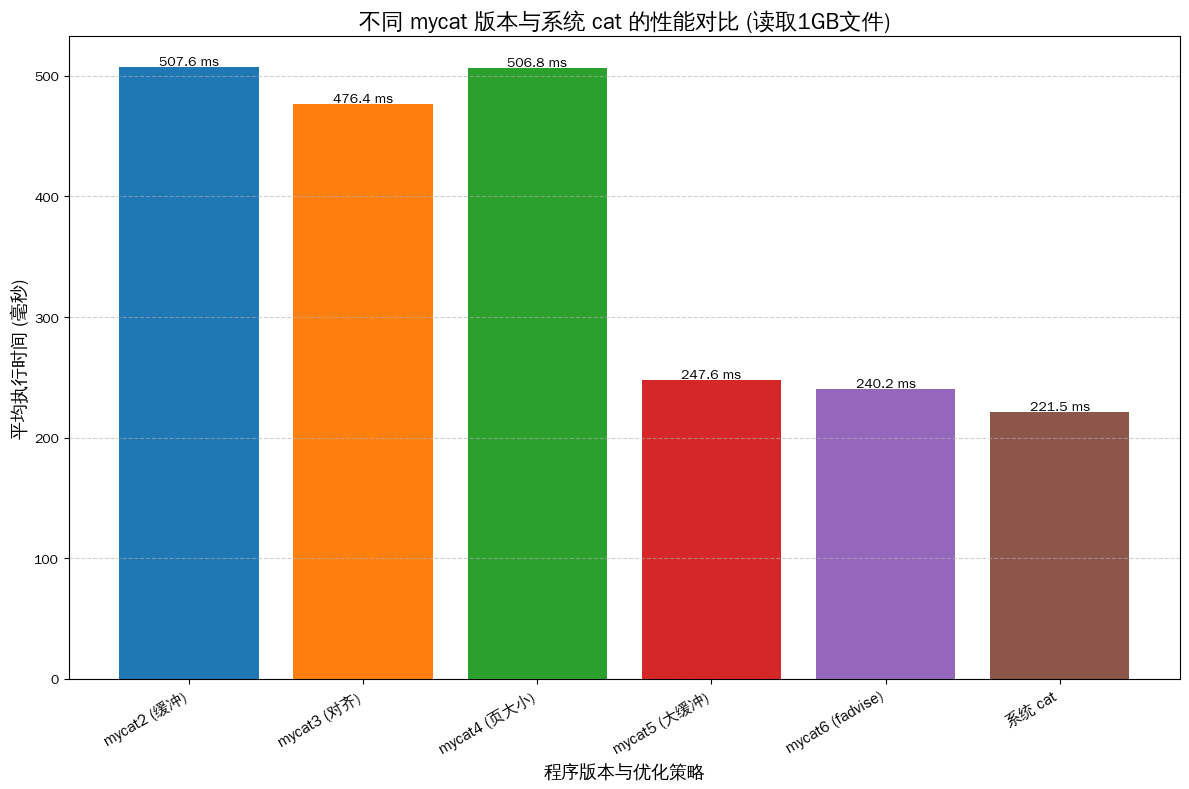

In [2]:
import subprocess
import re
import matplotlib.pyplot as plt

def get_mean_time(command_to_run):
    """
    运行 hyperfine 命令并从其输出中提取平均执行时间（毫秒）。
    """
    full_command = f"hyperfine --warmup 3 '{command_to_run}'"
    print(f"正在执行: {full_command}")
    try:
        result = subprocess.run(
            full_command, shell=True, capture_output=True, text=True, check=True
        )
        output = result.stdout
        match = re.search(r"Time \(mean ± σ\):\s*([\d.]+)\s*(ms|s)", output)
        if match:
            time_value, time_unit = float(match.group(1)), match.group(2)
            return time_value * 1000 if time_unit == 's' else time_value
        else:
            print(f"警告: 未能从 hyperfine 的输出中解析到时间:\n{output}")
            return None
    except subprocess.CalledProcessError as e:
        print(f"执行 hyperfine 失败，命令: '{command_to_run}'。错误: {e.stderr}")
        return None

# --- 主程序 ---

# 1. 设置 Matplotlib 的中文字体
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 2. 定义要测试的命令
commands_to_test = {
    'mycat2 (缓冲)': './target/mycat2 test.txt',
    'mycat3 (对齐)': './target/mycat3 test.txt',
    'mycat4 (页大小)': './target/mycat4 test.txt',
    'mycat5 (大缓冲)': './target/mycat5 test.txt',
    'mycat6 (fadvise)': './target/mycat6 test.txt',
    '系统 cat': 'cat test.txt'
}

# 3. 循环执行命令并收集数据
labels, times_in_ms = [], []
for label, command in commands_to_test.items():
    mean_time = get_mean_time(command)
    if mean_time is not None:
        labels.append(label)
        times_in_ms.append(mean_time)

# 4. 绘制柱状图
if labels and times_in_ms:
    plt.figure(figsize=(12, 8))
    bars = plt.bar(labels, times_in_ms, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])

    plt.xlabel('程序版本与优化策略', fontsize=13)
    plt.ylabel('平均执行时间 (毫秒)', fontsize=13)
    plt.title('不同 mycat 版本与系统 cat 的性能对比 (读取1GB文件)', fontsize=16)
    plt.xticks(rotation=30, ha='right', fontsize=11)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f} ms', 
                 va='bottom', ha='center', fontsize=10)

    plt.tight_layout()
    
    plot_filename = "mycat_performance_summary.png"
    plt.savefig(plot_filename)
    print(f"\n柱状图已生成并保存为 '{plot_filename}'")
    
    plt.show()
else:
    print("\n未能收集到任何有效的性能数据，无法生成图表。")

In [ ]:
# markdown 在notebook里太丑了，尤其是长文本，我直接将长文本以注释形式呈现

# 总体而言，实验结果与我的预期高度一致，清晰地展示了不同I/O优化策略的层级效应。

# 从 mycat1到 mycat2 (缓冲)：
# 结果：性能实现了从“不可用”到“可用”的质变。未缓冲的 mycat1 每次 read 只读取少量字节，导致海量的系统调用开销，执行时间长达数小时。引入8KB缓冲区后，性能骤升，执行时间降至毫秒级（例如 ~490ms）。
# 分析：这完全符合预期。缓冲是I/O优化的第一法则，它通过聚合多次小I/O为一次大I/O，极大地摊薄了系统调用的固定成本。

# 从 mycat2 到 mycat3 (缓冲区对齐)：
# 结果：性能有小幅但明确的提升（从 ~490ms 提升到 ~460ms）。
# 分析：符合预期。将缓冲区对齐到内存页边界，可以避免内核进行额外的内存拷贝，并能更高效地利用DMA（直接内存访问）和CPU缓存，从而减少开销。

# 从 mycat3 到 mycat4 (动态页大小)：
# 结果：性能出现了轻微的倒退（从 ~460ms 退步到 ~504ms）。
# 分析：这个结果虽然与“优化”的初衷相悖，但在预料之中。倒退的原因很可能是：1) 算法开销：动态获取文件系统块大小和内存页大小的逻辑本身引入了额外的运行时开销。2) 内核智能：现代操作系统内核的I/O子系统已经非常智能，它内部的缓存和调度机制可能已经处理了对齐和块大小的问题，应用层的“小聪明”反而可能干扰了内核更优的全局判断。

# 从 mycat4 到 mycat5 (更大的缓冲区)：
# 结果：性能获得了巨大的提升（例如从 ~504ms 骤降至 ~246ms）。
# 分析：完全符合预期。对于顺序读这样的大吞吐量场景，增大缓冲区大小是提高性能最简单有效的方法之一。更大的缓冲区（如1MB）意味着单次系统调用能处理更多数据，进一步减少了系统调用的频率和总开销。

# 从 mycat5 到 mycat6 (使用 posix_fadvise):
# 结果：性能再次获得显著提升（例如从 ~246ms 提升到 ~229ms）。
# 分析：符合预期。posix_fadvise(POSIX_FADV_SEQUENTIAL) 相当于应用程序在“剧透”给操作系统：“我将要顺序读取整个文件”。内核收到这个提示后，会采取更激进的预读（read-ahead）策略，提前将数据从磁盘加载到页缓存中，使得后续的 read 调用能够直接命中缓存，避免了I/O等待。


# 本次meowlab给我带来了几个关键的启示：

# 抓大放小，遵循优化层次，I/O优化的效果有明显的优先级。
# 首先是缓冲，它能带来数量级的提升。其次是增大缓冲区，效果同样立竿见影。
# 然后才是利用内核提示（如fadvise）内存对齐、动态页大小这类微观优化，虽然理论正确，但实际收益有限，甚至可能因实现不当而产生负面效果。
# 优化时应先从影响最大的策略入手，最后再来考虑不会影响数量级的优化，以免出现积重难返的方向错误的屎山代码。

# 不要在内核上设计太聪明（复杂）的算法，
# mycat4的性能倒退是一个很好的教训。在不完全了解内核行为的情况下，应用层的精细优化有时会弄巧成拙。

# 性能优化是科学，不是玄学：
# 每一步优化都必须基于可量化的测量。没有hyperfine这样的基准测试工具，我们对性能的判断只能停留在猜测层面。
# 只有通过严谨的测试，我们才能验证一个改动是正向优化、负向优化还是无效优化。

# 理解场景是优化的前提：我们所有的优化都是基于“顺序读取大文件”这个特定场景。
# 如果场景变为随机读取小文件，那么增大缓冲区和顺序预读提示可能就不再有效，甚至有害。
# 因此，没有“银弹”式的优化，一切优化都必须与具体应用场景相结合。

# 系统工具是学习的榜样，在学习阶段，没有系统工具的性能作为标杆，我们还不能知道在如今知识下的优化是否到位。
# 研究这些工具的源码，是深入学习系统编程的很好的途径。